<a href="https://colab.research.google.com/github/Leon-web-net/Machine_Learning/blob/NN_Binary_Classification/NeuralNetworkClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Neural Network classification with Pytorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple options).

## Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples,noise=0.03, random_state=42)

In [2]:
len(X), len(y)
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label":y
    })

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


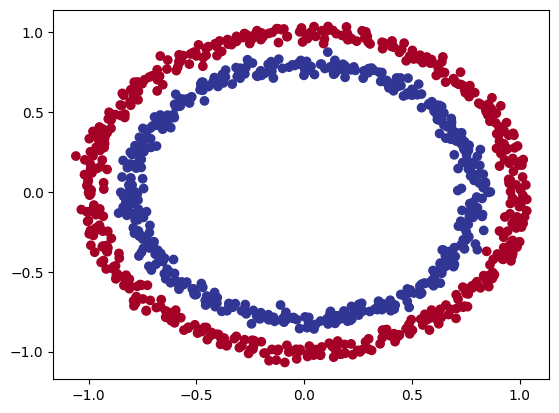

In [4]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data used is often referred to as a toy dataset, small enough to experiment but still sizeable enough to practice fundamentals

## Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X:{X_sample} and the same for y:{y_sample}")
print(f"Shapes for one sample of X:{X_sample.shape} and the same for y:{y_sample.shape}")

Values for one sample of X:[0.75424625 0.23148074] and the same for y:1
Shapes for one sample of X:(2,) and the same for y:()


## Turn data into tensors and create train and test splits

In [7]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [8]:
# Turn data into tensors
import torch

X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, # 0.2 = 20% of data is test
                                                    random_state=42
                                                    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## Building a Model

Build a model to classify our blue and red dots.
To do so:

1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define loss fucntion and optimizer
4. Create a training and test loop

In [11]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create a model

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass
4. Make instance of our model class and send it to target device

In [12]:
# 1. Construct a model that subclasses nn.Module
class CircleModel_0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capbale of handling shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes 2 features, upscales to 5
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes 5 features, output single feature same shape as y

  # 3. Define a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModel_0().to(device)
model_0, next(model_0.parameters()).device

(CircleModel_0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [13]:
# Replicate the model using nn.Sequential()
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5,),
#     nn.Linear(in_features=5, out_features=1)
#     ).to(device)

model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.6685,  0.0195],
                      [-0.0501, -0.4814],
                      [ 0.3269,  0.0159],
                      [-0.4021, -0.4060],
                      [ 0.3133, -0.0039]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.3640,  0.3341, -0.1050, -0.5692,  0.5081], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0084,  0.0901, -0.2444,  0.2798, -0.2206]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2291], device='cuda:0'))])

In [14]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of prediction: {len(untrained_preds)}, Shape:{untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape:{X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of prediction: 200, Shape:torch.Size([200, 1])
Length of test samples: 200, Shape:torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.4594],
        [-0.6055],
        [-0.2143],
        [-0.5282],
        [-0.4333],
        [-0.5209],
        [-0.7587],
        [-0.7395],
        [-0.2054],
        [-0.6177]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
X_test[:10],y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### Setup loss function and optimizer

Which loss function or optimizer should you use?

This is problem specific

* For regression MAE or MSE
* For classification you might want binary cross entropy or categorical cross entropy (cross entropy)


For optimizers, two of the most common are SGD and Adam. Pytorch has many other built-in options

For this model `BCEWithLogitLoss()` is used (binary cross entropy).



In [16]:
# Setup the loss function
# loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function
loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activation function built-in. Combine sigmoid + BCELoss

# set learning rate
LEARNING_RATE = 0.01
# set optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

In [17]:
# Calculate accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train Model

1. Forward pass
2. Calculate loss
3. Zero grad
4. Perform backpropagation (loss backward)
5. Step optimizer (gradient descent)

### Raw logits -> prediction probabilities -> prediction labels

Raw output of our model is referred to as **logits**

**Logits** can be converted into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Model prediction probabilities can be converted to prediction labels by either rounding them or taking the `argmax`.

In [18]:
# View the first 5 outputs of the forward pass on test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4594],
        [-0.6055],
        [-0.2143],
        [-0.5282],
        [-0.4333]], device='cuda:0')

In [19]:
# Use Sigmoid activation function on our model logits to turn them into predictions
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3871],
        [0.3531],
        [0.4466],
        [0.3709],
        [0.3933]], device='cuda:0')

For our prediction probability values, we need to perform range-style rounding on them.
* `y_pred_probs` >=0.5, `y=1` (class 1)
* `y_pred_probs` <0.5, `y-0` (class 0)

In [20]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [21]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits-> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze())) # squeeze gets rid of extra dim

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building a training and test loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turns logits -> pred probs -> pred labels

  # 2. Calculate accuracy
  loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  # For nn.BCELoss
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) # expects prediction probabilities as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72358, Acc: 50.00% | Test loss: 0.71768, Test acc: 50.00%
Epoch: 10 | Loss: 0.72112, Acc: 50.00% | Test loss: 0.71524, Test acc: 50.00%
Epoch: 20 | Loss: 0.71888, Acc: 50.00% | Test loss: 0.71304, Test acc: 50.00%
Epoch: 30 | Loss: 0.71685, Acc: 50.00% | Test loss: 0.71104, Test acc: 50.00%
Epoch: 40 | Loss: 0.71501, Acc: 50.00% | Test loss: 0.70924, Test acc: 50.00%
Epoch: 50 | Loss: 0.71334, Acc: 50.00% | Test loss: 0.70760, Test acc: 50.00%
Epoch: 60 | Loss: 0.71182, Acc: 50.00% | Test loss: 0.70611, Test acc: 50.00%
Epoch: 70 | Loss: 0.71044, Acc: 50.00% | Test loss: 0.70476, Test acc: 50.00%
Epoch: 80 | Loss: 0.70918, Acc: 50.00% | Test loss: 0.70354, Test acc: 50.00%
Epoch: 90 | Loss: 0.70803, Acc: 50.00% | Test loss: 0.70243, Test acc: 50.00%


## Make predictions and evaluate the model

From metrics it look like our model is not learning anything

**VISUALIZE!**

To do so, import a function called `plot_decision_boundary()`.

In [24]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

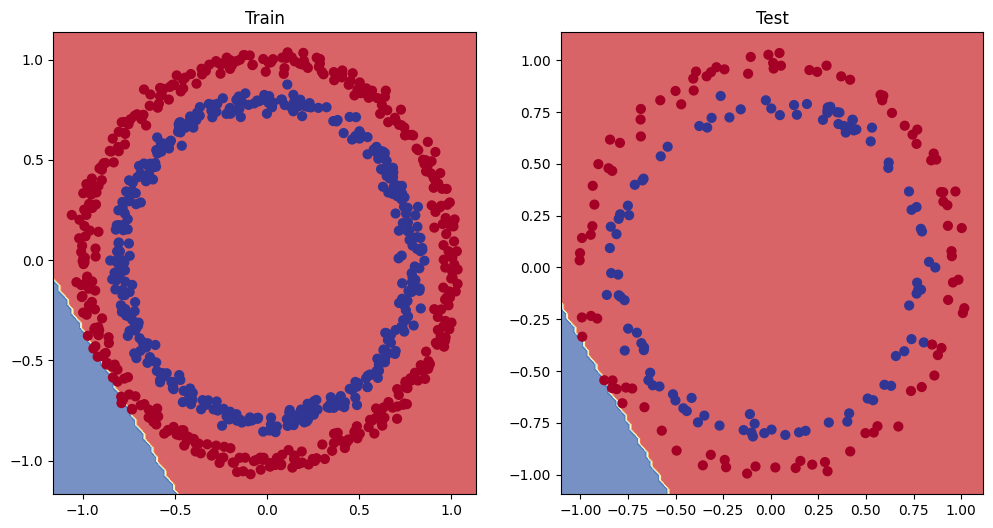

In [25]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a Model

* Add more layers - give model more chances to learn about pattern in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (more epochs)
* Changing the activation functions
* Change the learning rate (how much the optimizer will adjust each epoch, exploding and vanishing gradient problem)
* Change the loss function


These are all hyperparameters as they are values we can change.

Parameters are values the model updates by itself.


Let's try improve the model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000

In [26]:
class CircleModel_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)


  def forward(self,x):
     # this way of writing operations leverages speed ups
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModel_1().to(device)
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [33]:
# create loss function
loss_fn = nn.BCEWithLogitsLoss()
LEARNING_RATE = 0.01

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)


In [35]:
# Write training loop and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Set to train mode
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> predictions

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred= y_pred,)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation, calculate loss with respect to each param)
  loss.backward()

  # 5. Optimizer Step (gradient descent; update param based on gradients in loss function )
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred= test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69369, Acc: 50.25 | Test loss: 0.69269, Test acc: 50.00%
Epoch: 200 | Loss: 0.69351, Acc: 50.12 | Test loss: 0.69282, Test acc: 49.50%
Epoch: 300 | Loss: 0.69339, Acc: 50.50 | Test loss: 0.69295, Test acc: 49.00%
Epoch: 400 | Loss: 0.69329, Acc: 50.38 | Test loss: 0.69309, Test acc: 48.50%
Epoch: 500 | Loss: 0.69322, Acc: 49.88 | Test loss: 0.69322, Test acc: 49.50%
Epoch: 600 | Loss: 0.69317, Acc: 49.50 | Test loss: 0.69335, Test acc: 53.00%
Epoch: 700 | Loss: 0.69313, Acc: 49.38 | Test loss: 0.69347, Test acc: 50.50%
Epoch: 800 | Loss: 0.69309, Acc: 50.00 | Test loss: 0.69358, Test acc: 51.00%
Epoch: 900 | Loss: 0.69307, Acc: 50.62 | Test loss: 0.69368, Test acc: 47.50%


# Model still not working???? Non-Linearity

We are using linear function to learn a non-linear pattern and therefore the model is unable to learn.

# Recreating non-linear data (red and blue circles)

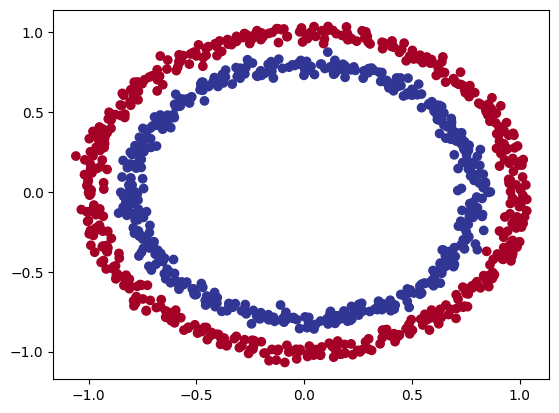

In [45]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise =0.03,
                   random_state=42)

plt.scatter(X[:,0],X[:,1], c=y,cmap=plt.cm.RdYlBu)

In [52]:
X[:5,:2],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [46]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Build model with Non-Linearity


In [53]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModel_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    # Relu between linear layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModel_2().to(device)
model_2

CircleModel_2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [63]:
# Loss function, optimizer, lr
LEARNING_RATE = 0.1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr =LEARNING_RATE)

In [65]:
### Train
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Set to train mode
  model_2.train()

  # 1. Forward pass
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc =  accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. backwards loss (backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  ### Eval
  model_2.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true= y_test,
                           y_pred= test_pred)

     # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.17121, Acc: 99.50 | Test loss: 0.22047, Test acc: 97.50%
Epoch: 100 | Loss: 0.12151, Acc: 99.75 | Test loss: 0.16470, Test acc: 99.00%
Epoch: 200 | Loss: 0.09100, Acc: 99.88 | Test loss: 0.12713, Test acc: 99.50%
Epoch: 300 | Loss: 0.07086, Acc: 99.88 | Test loss: 0.10303, Test acc: 99.50%
Epoch: 400 | Loss: 0.05763, Acc: 99.88 | Test loss: 0.08660, Test acc: 99.50%
Epoch: 500 | Loss: 0.04845, Acc: 99.88 | Test loss: 0.07465, Test acc: 99.50%
Epoch: 600 | Loss: 0.04171, Acc: 99.88 | Test loss: 0.06577, Test acc: 100.00%
Epoch: 700 | Loss: 0.03624, Acc: 99.88 | Test loss: 0.05972, Test acc: 100.00%
Epoch: 800 | Loss: 0.03201, Acc: 99.88 | Test loss: 0.05455, Test acc: 100.00%
Epoch: 900 | Loss: 0.02869, Acc: 99.88 | Test loss: 0.05018, Test acc: 100.00%
